In [264]:
import seaborn as sns
import pandas as pd
import numpy as np
import json
import glob
import re
import matplotlib.pyplot as plt
import math
import tqdm
import matplotlib.dates as mdates
import matplotlib as mpl
import sys
sns.set(font_scale=0.9, style='whitegrid', font='CMU Sans Serif')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.figsize'] = (4.5,3)
mpl.rcParams['figure.dpi'] = 100

pd.set_option('mode.chained_assignment', None)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def save_fig(ax, name, file_type="pdf"):
    fig = ax.get_figure()
    fig.tight_layout()
    file_name = name + "." + file_type
    fig.savefig(os.path.join("graphs", file_name), bbox_inches='tight')

In [265]:
async_folder = "logs/20_P"
sync_folder = "logs/21_Q" # prev: 13_J

experiment_phase_ms = {
    "begin": 0,
    "high_end": 600_000,
    "line_end": 1_200_000,
    "end": 1_800_000
}

__color_palette = sns.color_palette("colorblind", 10)
color_map = {
    "async": __color_palette[0],
    "sync": __color_palette[1],
    "cpu": __color_palette[2],
    "check": __color_palette[3],
    "virus": __color_palette[4],
    "ocr": __color_palette[5],
    "email": __color_palette[6],
}

In [283]:
def get_experiment_dfs(folder, experiment):
    call_lines = []
    k6_durations = []
    for file_name in glob.glob("*.log", root_dir=folder):
        with open(folder + "/" + file_name) as f:
            while line := f.readline():
                if "PFSTT" in line and "dashboard is deleting returned header" not in line:
                    json_string = re.search(r'PFSTT(.*?)TTSFP', line).group(1)
                    try:
                        call_lines.append(json.loads(json_string))
                    except:
                        print("Error in file: " + file_name)
                        print("Line: " + line)
                        print("JSON: " + json_string)
                        print("-----")
                        continue
                if "K6MAGICSTRING" in line:
                    raw_data = re.search(r'K6MAGICSTRING(.*?)K7MAGICSTRING', line).group(1)
                    splits = raw_data.split(",")
                    req_duration = float(splits[2].strip())
                    callid = splits[1].strip()
                    start_unix = float(splits[0].strip())
                    k6_durations.append({
                        "start_unix": start_unix,
                        "req_duration_ms": req_duration,
                        "callid": callid,
                    })
    invocation_df = pd.DataFrame(call_lines)
    k6_df = pd.DataFrame(k6_durations)

    first_call_ms = k6_df["start_unix"].min()
    last_finished_ms = invocation_df["end"].max()

    # Start cleaning up the existing DFs, starting with invocaiton_df
    # set data types to float for all numeric columns
    invocation_df = invocation_df.astype({
        "start": float,
        "end": float,
        "request_timestamp": float,
        "request_deadline": float,
    })
    invocation_df["experiment"] = experiment
    invocation_df["start_ms"] = invocation_df["start"] - first_call_ms
    invocation_df["end_ms"] = invocation_df["end"] - first_call_ms
    invocation_df["request_timestamp_ms"] = invocation_df["request_timestamp"] - first_call_ms
    invocation_df["request_deadline_ms"] = invocation_df["request_deadline"] - first_call_ms
    invocation_df["duration_ms"] = invocation_df["end_ms"] - invocation_df["start_ms"]

    # Now clean k6_df
    k6_df["start_ms"] = k6_df["start_unix"] - first_call_ms
    # ...rest should already be cleaned
    k6_df["end_ms"] = k6_df["start_ms"] + k6_df["req_duration_ms"]

    if len(k6_df["callid"].unique()) != len(invocation_df["callid"].unique()):
        print("Mismatched callids", file=sys.stderr)
        #return None


    def process_calls_with_callid(callid):
        k6_req = k6_df[k6_df["callid"] == callid]
        calls = invocation_df[invocation_df["callid"] == callid]
        if len(calls) != 4:
            print(f"Call {callid} has {len(calls)} calls in experiment {experiment}", file=sys.stderr)
            return None
        if len(k6_req) != 1:
            print(f"Call {callid} has {len(k6_req)} k6 requests in experiment {experiment}", file=sys.stderr)
            return None
        start_ms = k6_req["start_ms"].values[0] # when the k6 request started
        end_ms = k6_req["end_ms"].values[0] # when the k6 request ended
        req_duration_ms = k6_req["req_duration_ms"].values[0] # how long the k6 request took according kto k6
        # Now find the run_duration of the call, which is the sum of the durations of the 4 calls
        run_duration_ms = calls["duration_ms"].sum()
        start = k6_req["start_unix"].values[0]
        
        return {
            "callid": callid,
            "experiment": experiment,
            "start": start,
            "start_ms": start_ms,
            "end_ms": end_ms,
            "req_duration_ms": req_duration_ms,
            "run_duration_ms": run_duration_ms,
        }
    
    # Ignore all None values, they are errors
    workflow_df = pd.DataFrame([x for x in map(process_calls_with_callid, k6_df["callid"].unique()) if x is not None])

    # add start_dt, end_dt, request_timestamp_dt, request_deadline_dt, duration_td
    invocation_df["start_dt"] = pd.to_datetime(invocation_df["start_ms"], unit="ms")
    invocation_df["end_dt"] = pd.to_datetime(invocation_df["end_ms"], unit="ms")
    invocation_df["request_timestamp_dt"] = pd.to_datetime(invocation_df["request_timestamp_ms"], unit="ms")
    invocation_df["request_deadline_dt"] = pd.to_datetime(invocation_df["request_deadline_ms"], unit="ms")
    invocation_df["duration_td"] = pd.to_timedelta(invocation_df["duration_ms"], unit="ms")

    # add dt and td columns to workflow_df
    workflow_df["start_dt"] = pd.to_datetime(workflow_df["start_ms"], unit="ms")
    workflow_df["end_dt"] = pd.to_datetime(workflow_df["end_ms"], unit="ms")
    workflow_df["req_duration_td"] = pd.to_timedelta(workflow_df["req_duration_ms"], unit="ms")
    workflow_df["run_duration_td"] = pd.to_timedelta(workflow_df["run_duration_ms"], unit="ms")

    # sort all by start_dt
    invocation_df = invocation_df.sort_values(by="start_dt")
    workflow_df = workflow_df.sort_values(by="start_dt")

    return (invocation_df, workflow_df)

s_i_df, s_w_df = get_experiment_dfs(sync_folder, "sync")
a_i_df, a_w_df = get_experiment_dfs(async_folder, "async")
o_w_df = pd.concat([s_w_df, a_w_df])
o_i_df = pd.concat([s_i_df, a_i_df])

Mismatched callids
Call b9377cd1acc8429f84993b44a4a4e777 has 3 calls in experiment async
Call eb10b6d249a34ed081abc4a0bc228854 has 3 calls in experiment async
Call 6159a74425e745889616af6ba55fb958 has 3 calls in experiment async
Call 3b16387b78af4a08b9a5804987fc46ae has 3 calls in experiment async
Call b82c2934e75e4f399bc7da967f5d76f2 has 3 calls in experiment async
Call e7f02c14c24f47bb86e3dfd5d6ef241f has 1 calls in experiment async
Call fce7c10b71474f55ae9a15f3beaad2cd has 1 calls in experiment async


In [267]:
print(len(s_w_df))
print(len(a_w_df))

1801
1793


In [268]:
__smaller_dfs = []
for file_name in glob.glob("*.csv", root_dir="usage/"):
    with open("usage/" + file_name) as f:
        __smaller_dfs.append(pd.read_csv(f))
__usage_df = pd.concat(__smaller_dfs)

def get_cpu_share(start, end, current):
    # get the length of the experiment
    length = end - start
    # get the current time in the experiment
    current = current - start

    # if the current time is in the first third of the experiment
    if current < length/3:
        return "0.80"
    # if the current time is in the last third of the experiment, but not after the experiment
    elif current > 2*length/3 and current < length:
        return "0.15"
    # after the experiment, its 0
    elif current > length:
        return "0.00"
    # if the current time is in the middle third of the experiment
    else:
        # calculate the cpu share based on the current time
        return str(round(((-1.95/length)*current + 1.45), 2))
        # the value if you want to go from 50 to 15:
        # return str(round(((-105/length)*current + 85)/100, 2))

def get_cpu_df_from_i_and_w_df(i_df, w_df, experiment):
    min_relevant_unix = w_df["start"].min()
    max_relevant_unix = i_df["end"].max()
    cpu_df = __usage_df[(__usage_df["unix_time"] >= min_relevant_unix) & (__usage_df["unix_time"] <= max_relevant_unix)]
    cpu_df["time_ms"] = cpu_df["unix_time"] - min_relevant_unix
    
    # add time_ms and time_dt as time since the start of the experiment
    cpu_df["time_ms"] = cpu_df["unix_time"] - min_relevant_unix
    cpu_df["time_dt"] = pd.to_datetime(cpu_df["time_ms"], unit="ms")

    # add what the base cpu share was at the time
    cpu_df["base_cpu_share"] = cpu_df.apply(lambda row: float(get_cpu_share(experiment_phase_ms["begin"], experiment_phase_ms["end"], row["time_ms"])) * 100, axis=1)

    cpu_df["experiment"] = experiment

    # This df has cpu_percent and ram_percent as values between 0 and 100
    return cpu_df

s_c_df = get_cpu_df_from_i_and_w_df(s_i_df, s_w_df, "sync")
a_c_df = get_cpu_df_from_i_and_w_df(a_i_df, a_w_df, "async")
s_c_df["cpu_percent_minus_baseline"] = s_c_df["cpu_percent"] - s_c_df["base_cpu_share"]
a_c_df["cpu_percent_minus_baseline"] = a_c_df["cpu_percent"] - a_c_df["base_cpu_share"]
c_df = pd.concat([s_c_df, a_c_df])

In [269]:
# list all columns of s_i_df
print(s_w_df.columns)

Index(['callid', 'experiment', 'start', 'start_ms', 'end_ms',
       'req_duration_ms', 'run_duration_ms', 'start_dt', 'end_dt',
       'req_duration_td', 'run_duration_td'],
      dtype='object')


In [270]:
# generate a rolling df for both u_df and both w_df and for both c_df
__i_df_rollable_cols = ['start_dt', 'request_deadline_ms', 'duration_ms', 'start_ms']

# generate a rolling df for i_df and w_df
r_s_i_df = s_i_df[__i_df_rollable_cols].rolling("30s", on="start_dt").mean()
r_a_i_df = a_i_df[__i_df_rollable_cols].rolling("30s", on="start_dt").mean()

__w_df_rollable_cols = ['start_dt', 'req_duration_ms', 'run_duration_ms', 'start_ms']

r_s_w_df = s_w_df[__w_df_rollable_cols].rolling("30s", on="start_dt").mean()
r_a_w_df = a_w_df[__w_df_rollable_cols].rolling("30s", on="start_dt").mean()

# generate a rolling df for both c_df
__c_df_rollable_cols = ['time_dt', 'cpu_percent', 'ram_percent', 'base_cpu_share']
r_s_c_df = s_c_df[__c_df_rollable_cols].rolling("30s", on="time_dt").mean()
r_a_c_df = a_c_df[__c_df_rollable_cols].rolling("30s", on="time_dt").mean()


In [271]:
print("CPU Usage")
s_c_df_phase_1 = s_c_df[(s_c_df["time_ms"] > experiment_phase_ms["begin"]) & (s_c_df["time_ms"] < experiment_phase_ms["high_end"])]
a_c_df_phase_1 = a_c_df[(a_c_df["time_ms"] > experiment_phase_ms["begin"]) & (a_c_df["time_ms"] < experiment_phase_ms["high_end"])]
s_c_df_phase_2 = s_c_df[(s_c_df["time_ms"] > experiment_phase_ms["high_end"]) & (s_c_df["time_ms"] < experiment_phase_ms["line_end"])]
a_c_df_phase_2 = a_c_df[(a_c_df["time_ms"] > experiment_phase_ms["high_end"]) & (a_c_df["time_ms"] < experiment_phase_ms["line_end"])]
s_c_df_phase_3 = s_c_df[(s_c_df["time_ms"] > experiment_phase_ms["line_end"]) & (s_c_df["time_ms"] < experiment_phase_ms["end"])]
a_c_df_phase_3 = a_c_df[(a_c_df["time_ms"] > experiment_phase_ms["line_end"]) & (a_c_df["time_ms"] < experiment_phase_ms["end"])]

print(f"Average CPU Over Baseline during the high phase: async: {a_c_df_phase_1['cpu_percent_minus_baseline'].mean()}, sync: {s_c_df_phase_1['cpu_percent_minus_baseline'].mean()}")
print(f"Average CPU during phase 1: async: {a_c_df_phase_1['cpu_percent'].mean()}, sync: {s_c_df_phase_1['cpu_percent'].mean()}")

print(f"Average CPU Over Baseline during the line phase: async: {a_c_df_phase_2['cpu_percent_minus_baseline'].mean()}, sync: {s_c_df_phase_2['cpu_percent_minus_baseline'].mean()}")
print(f"Average CPU during phase 2: async: {a_c_df_phase_2['cpu_percent'].mean()}, sync: {s_c_df_phase_2['cpu_percent'].mean()}")

print(f"Average CPU Over Baseline during the end phase: async: {a_c_df_phase_3['cpu_percent_minus_baseline'].mean()}, sync: {s_c_df_phase_3['cpu_percent_minus_baseline'].mean()}")
print(f"Average CPU during phase 3: async: {a_c_df_phase_3['cpu_percent'].mean()}, sync: {s_c_df_phase_3['cpu_percent'].mean()}")

print("-----")
print("Request Response Latencies")
s_w_df_phase_1 = s_w_df[(s_w_df["start_ms"] > experiment_phase_ms["begin"]) & (s_w_df["start_ms"] < experiment_phase_ms["high_end"])]
a_w_df_phase_1 = a_w_df[(a_w_df["start_ms"] > experiment_phase_ms["begin"]) & (a_w_df["start_ms"] < experiment_phase_ms["high_end"])]
s_w_df_phase_2 = s_w_df[(s_w_df["start_ms"] > experiment_phase_ms["high_end"]) & (s_w_df["start_ms"] < experiment_phase_ms["line_end"])]
a_w_df_phase_2 = a_w_df[(a_w_df["start_ms"] > experiment_phase_ms["high_end"]) & (a_w_df["start_ms"] < experiment_phase_ms["line_end"])]
s_w_df_phase_3 = s_w_df[(s_w_df["start_ms"] > experiment_phase_ms["line_end"]) & (s_w_df["start_ms"] < experiment_phase_ms["end"])]
a_w_df_phase_3 = a_w_df[(a_w_df["start_ms"] > experiment_phase_ms["line_end"]) & (a_w_df["start_ms"] < experiment_phase_ms["end"])]
print(f"Average Request Latency during phase 1: async: {a_w_df_phase_1['req_duration_ms'].mean()}, sync: {s_w_df_phase_1['req_duration_ms'].mean()}")
print(f"Average Request Latency during phase 2: async: {a_w_df_phase_2['req_duration_ms'].mean()}, sync: {s_w_df_phase_2['req_duration_ms'].mean()}")
print(f"Average Request Latency during phase 3: async: {a_w_df_phase_3['req_duration_ms'].mean()}, sync: {s_w_df_phase_3['req_duration_ms'].mean()}")

print("-----")
print("Std Deviation of Request Response Latencies")
print(f"Std Dev of Request Latency during phase 1: async: {a_w_df_phase_1['req_duration_ms'].std()}, sync: {s_w_df_phase_1['req_duration_ms'].std()}")
print(f"Std Dev of Request Latency during phase 2: async: {a_w_df_phase_2['req_duration_ms'].std()}, sync: {s_w_df_phase_2['req_duration_ms'].std()}")
print(f"Std Dev of Request Latency during phase 3: async: {a_w_df_phase_3['req_duration_ms'].std()}, sync: {s_w_df_phase_3['req_duration_ms'].std()}")
print(f"Overall Std Dev of Request Latency: async: {a_w_df['req_duration_ms'].std()}, sync: {s_w_df['req_duration_ms'].std()}")
print("-----")

CPU Usage
Average CPU Over Baseline during the high phase: async: 9.973006756756757, sync: 19.718813559322033
Average CPU during phase 1: async: 89.97300675675676, sync: 99.71881355932204
Average CPU Over Baseline during the line phase: async: 30.256486486486487, sync: 43.11989864864865
Average CPU during phase 2: async: 77.68891891891892, sync: 90.60976351351351
Average CPU Over Baseline during the end phase: async: 44.18356902356903, sync: 42.87286195286196
Average CPU during phase 3: async: 59.18356902356903, sync: 57.872861952861946
-----
Request Response Latencies
Average Request Latency during phase 1: async: 379.64346167946576, sync: 2083.391179789649
Average Request Latency during phase 2: async: 908.9288483838385, sync: 1901.908568262104
Average Request Latency during phase 3: async: 1481.8044576683417, sync: 1134.28693024
-----
Std Deviation of Request Response Latencies
Std Dev of Request Latency during phase 1: async: 214.50911715310792, sync: 1830.8065451115515
Std Dev of 

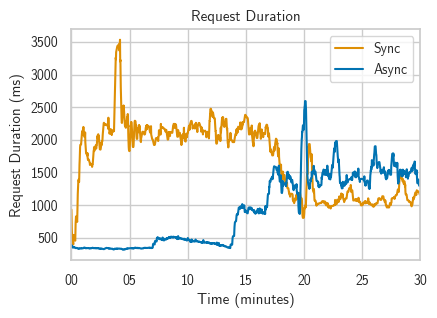

In [279]:
sns.lineplot(data=r_s_w_df, x="start_dt", y="req_duration_ms", label="Sync", color=color_map["sync"])
sns.lineplot(data=r_a_w_df, x="start_dt", y="req_duration_ms", label="Async", color=color_map["async"])
plt.ylabel("Request Duration (ms)")
plt.xlabel("Time (minutes)")
plt.title("Request Duration")
plt.xlim(pd.to_datetime(experiment_phase_ms["begin"], unit="ms"), pd.to_datetime(experiment_phase_ms["end"], unit="ms"))

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%M'))

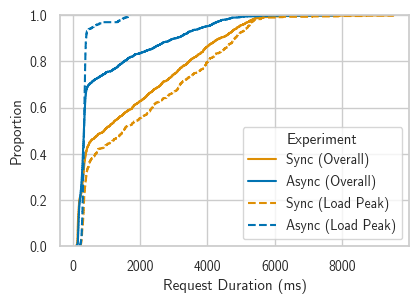

In [289]:
sns.ecdfplot(data=s_w_df, x="req_duration_ms", label="Sync (Overall)", color=color_map["sync"])
sns.ecdfplot(data=a_w_df, x="req_duration_ms", label="Async (Overall)", color=color_map["async"])

# get s_w_df and a_w_df where start_ms is smaller than experiment_phase_ms["high_end"]
s_w_df_phase_1 = s_w_df[s_w_df["start_ms"] < experiment_phase_ms["high_end"]]
a_w_df_phase_1 = a_w_df[a_w_df["start_ms"] < experiment_phase_ms["high_end"]]
sns.ecdfplot(data=s_w_df_phase_1, x="req_duration_ms", label="Sync (Load Peak)", color=color_map["sync"], linestyle="--")
sns.ecdfplot(data=a_w_df_phase_1, x="req_duration_ms", label="Async (Load Peak)", color=color_map["async"], linestyle="--")

plt.xlabel("Request Duration (ms)")

# Create a legend
plt.legend(title="Experiment", loc='lower right', labels=["Sync (Overall)", "Async (Overall)", "Sync (Load Peak)", "Async (Load Peak)"])

# Paper Graphs

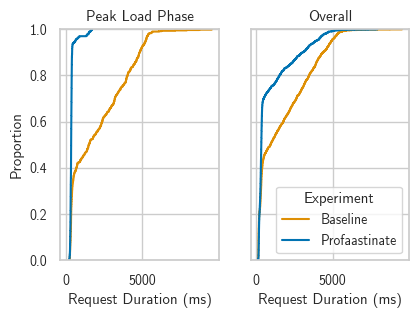

In [299]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(4.5, 3))


sns.ecdfplot(data=s_w_df_phase_1, x="req_duration_ms", label="Sync", color=color_map["sync"], ax=ax1)
sns.ecdfplot(data=a_w_df_phase_1, x="req_duration_ms", label="Async", color=color_map["async"], ax=ax1)

# plot the overall request duration on the right side
sns.ecdfplot(data=s_w_df, x="req_duration_ms", label="Sync", color=color_map["sync"], ax=ax2)
sns.ecdfplot(data=a_w_df, x="req_duration_ms", label="Async", color=color_map["async"], ax=ax2)

ax1.set_xlabel("Request Duration (ms)")
ax2.set_xlabel("Request Duration (ms)")
ax1.set_title("Peak Load Phase")
ax2.set_title("Overall")

# generate a legend
ax2.legend(title="Experiment", loc='lower right', labels=["Baseline", "Profaastinate"])

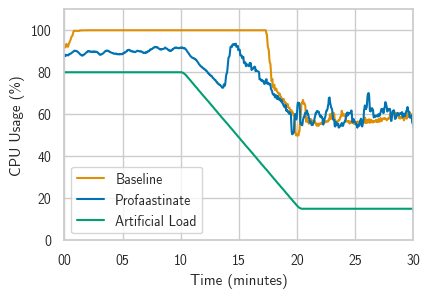

In [312]:
# Plot rolling CPU Usage
sns.lineplot(data=r_s_c_df, x="time_dt", y="cpu_percent", label="Baseline", color=color_map["sync"])
sns.lineplot(data=r_a_c_df, x="time_dt", y="cpu_percent", label="Profaastinate", color=color_map["async"])
# Plot the base cpu share
sns.lineplot(data=r_s_c_df, x="time_dt", y="base_cpu_share", label="Artificial Load", color=color_map["cpu"])
plt.ylabel("CPU Usage (%)")
plt.xlabel("Time (minutes)")
plt.xlim(pd.to_datetime(0, unit="ms"),pd.to_datetime(experiment_phase_ms["end"], unit="ms"))
plt.ylim(0,110)

# move the legend to the  bottom left
# re-use the existing legend handles
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
# create the new legend at the bottom left
ax.legend(handles=handles, labels=labels, loc='lower left')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%M'))

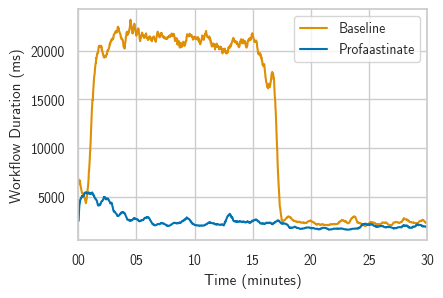

In [316]:
# Plot the total duration of the workflow
sns.lineplot(data=r_s_w_df, x="start_dt", y="run_duration_ms", label="Baseline", color=color_map["sync"])
sns.lineplot(data=r_a_w_df, x="start_dt", y="run_duration_ms", label="Profaastinate", color=color_map["async"])

plt.ylabel("Workflow Duration (ms)")
plt.xlabel("Time (minutes)")
plt.xlim(pd.to_datetime(experiment_phase_ms["begin"], unit="ms"), pd.to_datetime(experiment_phase_ms["end"], unit="ms"))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%M'))